# Plot the model outputs

In [1]:
import datetime
import pandas as pd
from simpler_mpl import set_common_mpl_styles
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import matplotlib.pyplot as plt
from simpler_pandas import apply_labelling, sanity_check, show_df_details
from labelling import format_to_base_10

%load_ext autoreload
%autoreload 2

In [2]:
MARKETING_COST_PER_INSURED = 20
VALUE_PER_RETAINED_CONTRACT = 1000
ONE_MILLION = 1_000_000

#economic = f"${VALUE_PER_RETAINED_CONTRACT:0.0f} earned per retained contract and ${MARKETING_COST_PER_INSURED:0.0f} cost per marketing action"
#economic

In [3]:
uplift_result_file = "df_comparison_uplift.pickle"
df_comparison_uplift = pd.read_pickle(uplift_result_file)
churn_result_file = "df_comparison_churn.pickle"
df_comparison_churn = pd.read_pickle(churn_result_file)
dummy_result_file = "df_comparison_dummy.pickle"
df_comparison_dummy = pd.read_pickle(dummy_result_file)

df_to_plot = pd.concat((df_comparison_dummy, df_comparison_churn, df_comparison_uplift), axis=1)

def check_series_is_ordered(ser, ascending=True):
    """Check 1 series is ascending"""
    assert ascending==True, "Haven't done descending yet, nor tested this"
    return (ser.shift()[1:].reset_index(drop=True) >= ser[:-1].reset_index(drop=True)).all()

assert check_series_is_ordered(df_to_plot['churn_proba_pos'])
assert check_series_is_ordered(df_to_plot['dummy_proba_pos'])
assert check_series_is_ordered(df_to_plot['uplift_diff_t_c'])

df_to_plot

,dummy_proba_pos,dummy_will_churn,churn_proba_pos,churn_will_churn,uplift_diff_t_c,uplift_will_churn
0,0.16007,0,0.215922,0,-0.062973,0
1,0.16007,0,0.215922,0,-0.062973,0
2,0.16007,0,0.215922,0,-0.062973,0
3,0.16007,0,0.215922,0,-0.062973,0
4,0.16007,0,0.215922,0,-0.062973,1
...,...,...,...,...,...,...
49995,0.16007,0,0.113977,0,0.064762,0
49996,0.16007,0,0.113977,0,0.064762,0
49997,0.16007,0,0.113977,0,0.064762,0
49998,0.16007,0,0.113977,0,0.064762,0


In [4]:
sanity_check(df_to_plot)
show_df_details(df_to_plot)

is view False, is consolidated False, single block False, numeric mixed True
6 blocks looking like:
(NumericBlock: slice(0, 1, 1), 1 x 50000, dtype: float64, NumericBlock: slice(1, 2, 1), 1 x 50000, dtype: int64, NumericBlock: slice(2, 3, 1), 1 x 50000, dtype: float64, NumericBlock: slice(3, 4, 1), 1 x 50000, dtype: int64, NumericBlock: slice(4, 5, 1), 1 x 50000, dtype: float64, NumericBlock: slice(5, 6, 1), 1 x 50000, dtype: int64)


In [5]:
def calculate_value_generated(dfx, col_will_churn, model_name):
    # assume we're sorted
    #df_costing = dfx.sort_values(col, ascending=ascending).copy().reset_index(drop=True)
    df_costing = dfx[[col_will_churn]].copy()
    #df_costing['price_if_mktd'] = -1
    #df_costing['price_if_mktd_cumsum'] = df_costing['price_if_mktd'].cumsum()
    #df_costing['price_if_retained'] = 1000 * (df_costing[col_will_churn]==0)
    value_column = f"{model_name}_value"
    df_costing[value_column] = (VALUE_PER_RETAINED_CONTRACT * (df_costing[col_will_churn]==0)) - MARKETING_COST_PER_INSURED
    value_column_cumsum = f"{model_name}_value_cumsum"
    df_costing[value_column_cumsum] = df_costing[value_column].cumsum()
    return df_costing[[value_column, value_column_cumsum]]

df_costing_uplift = calculate_value_generated(df_to_plot, "uplift_will_churn", "uplift")
#df_costing.iloc[10000]
df_costing_uplift

,uplift_value,uplift_value_cumsum
0,980,980
1,980,1960
2,980,2940
3,980,3920
4,-20,3900
...,...,...
49995,980,40990080
49996,980,40991060
49997,980,40992040
49998,980,40993020


In [6]:
df_costing_churn = calculate_value_generated(df_to_plot, "churn_will_churn", "churn")

In [7]:
df_costing_dummy = calculate_value_generated(df_to_plot, "dummy_will_churn", "dummy")

In [8]:
df_to_plot = pd.concat((df_costing_dummy, df_costing_churn, df_costing_uplift), axis=1)
df_to_plot.sample(5).sort_index()

,dummy_value,dummy_value_cumsum,churn_value,churn_value_cumsum,uplift_value,uplift_value_cumsum
1110,980,905780,-20,792780,980,902780
7512,-20,6155740,980,5774740,980,6462740
15671,-20,12827560,980,12172560,980,13413560
24399,980,20001000,980,19339000,-20,20599000
35623,-20,29208520,980,28582520,980,29829520


In [9]:
#row_with_minimum_uplift_effect = (0 - df_comparison_uplift['uplift_diff_t_c'].abs()).idxmax()
#row_with_minimum_uplift_effect
#print(f"By insured {row_with_minimum_uplift_effect:,} the Uplift model predicts subsequent rows will respond neutrally or negatively to this campaign")
#print(f"By this point we've incurred a marketing cost of ${MARKETING_COST_PER_INSURED * row_with_minimum_uplift_effect:,}.")
#df_to_plot.loc[row_with_minimum_uplift_effect]

In [10]:
row_choice = 10_000
print(f"By this point ({row_choice:,}) we've incurred a marketing cost of ${MARKETING_COST_PER_INSURED * row_choice:,}.")

df_to_plot.iloc[row_choice]

By this point (10,000) we've incurred a marketing cost of $200,000.


dummy_value                -20
dummy_value_cumsum     8191980
churn_value                -20
churn_value_cumsum     7739980
uplift_value               980
uplift_value_cumsum    8556980
Name: 10000, dtype: int64

In [11]:
row_choice = row_with_minimum_uplift_effect = (0 - df_comparison_uplift['uplift_diff_t_c'].abs()).idxmax()
print(f"By insured {row_choice:,} the Uplift model predicts subsequent rows will respond neutrally or negatively to this campaign")
print(f"By this point we've incurred a marketing cost of ${MARKETING_COST_PER_INSURED * row_choice:,}.")

df_to_plot.iloc[row_choice]

By insured 36,980 the Uplift model predicts subsequent rows will respond neutrally or negatively to this campaign
By this point we've incurred a marketing cost of $739,600.


dummy_value                 980
dummy_value_cumsum     30341380
churn_value                 980
churn_value_cumsum     29713380
uplift_value                980
uplift_value_cumsum    30945380
Name: 36980, dtype: int64

In [12]:
df_to_plot['dummy_value_cumsum'] = df_to_plot['dummy_value_cumsum'] / ONE_MILLION
df_to_plot['churn_value_cumsum'] = df_to_plot['churn_value_cumsum'] / ONE_MILLION
df_to_plot['uplift_value_cumsum'] = df_to_plot['uplift_value_cumsum'] / ONE_MILLION

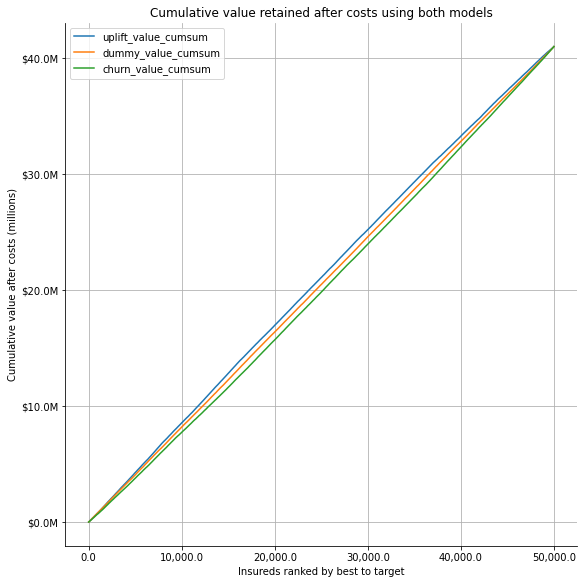

In [13]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
df_to_plot[:50_000].plot(y=['uplift_value_cumsum', 'dummy_value_cumsum', 'churn_value_cumsum'], ax=ax);
title = "Cumulative value retained after costs using both models"
set_common_mpl_styles(ax, grid_axis="both", xlabel="Insureds ranked by best to target", 
                      ylabel="Cumulative value after costs (millions)", title=title)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:}M'))

In [14]:
quantile = pd.cut(df_to_plot.index, 5, right=False)
quantile

[[0.0, 9999.8), [0.0, 9999.8), [0.0, 9999.8), [0.0, 9999.8), [0.0, 9999.8), ..., [39999.2, 50048.999), [39999.2, 50048.999), [39999.2, 50048.999), [39999.2, 50048.999), [39999.2, 50048.999)]
Length: 50000
Categories (5, interval[float64, left]): [[0.0, 9999.8) < [9999.8, 19999.6) < [19999.6, 29999.4) < [29999.4, 39999.2) < [39999.2, 50048.999)]

In [15]:
mean_result_by_quantile = df_to_plot.groupby(quantile)[['uplift_value', 'dummy_value', 'churn_value']].mean()
mean_result_by_quantile.index = apply_labelling(mean_result_by_quantile.index, format_to_base_10)
mean_result_by_quantile

,uplift_value,dummy_value,churn_value
[0.00 - 10.00k),855.6,819.2,774.0
[10.00k - 20.00k),841.2,820.1,797.5
[20.00k - 30.00k),824.6,820.6,825.1
[30.00k - 40.00k),805.8,822.2,836.4
[40.00k - 50.05k),772.1,817.2,866.3


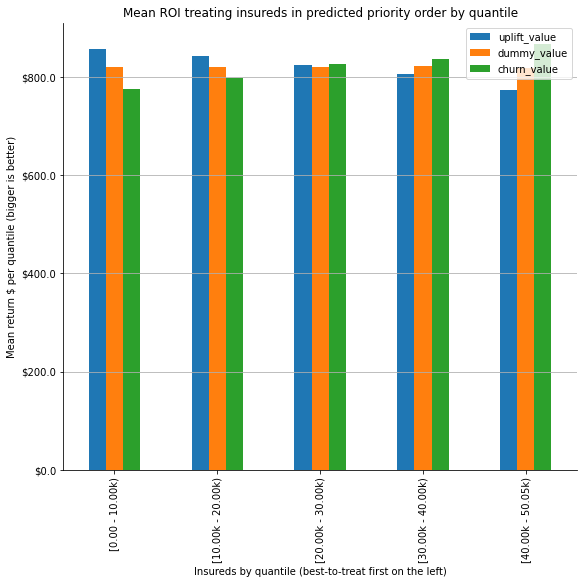

In [16]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
mean_result_by_quantile.plot(kind='bar', ax=ax)
title = "Mean ROI treating insureds in predicted priority order by quantile"
set_common_mpl_styles(ax, grid_axis="y", xlabel="Insureds by quantile (best-to-treat first on the left)", title=title, ylabel="Mean return $ per quantile (bigger is better)")
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

<AxesSubplot:>

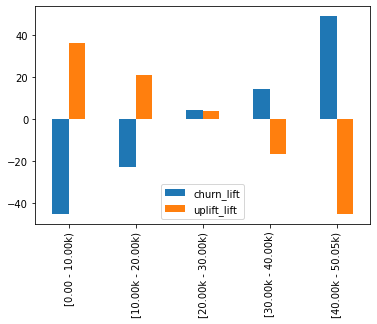

In [17]:
churn_from_dummy = mean_result_by_quantile['churn_value'] - mean_result_by_quantile['dummy_value']
uplift_from_dummy = mean_result_by_quantile['uplift_value'] - mean_result_by_quantile['dummy_value']
lift_from_dummy = pd.concat((churn_from_dummy, uplift_from_dummy), axis=1)
lift_from_dummy.columns = ['churn_lift', 'uplift_lift']
lift_from_dummy.plot(kind='bar')

In [18]:
sum_result_by_quantile = df_to_plot.groupby(quantile)[['uplift_value', 'dummy_value', 'churn_value']].sum()
sum_result_by_quantile.index = apply_labelling(sum_result_by_quantile.index, format_to_base_10)
sum_result_by_quantile

,uplift_value,dummy_value,churn_value
[0.00 - 10.00k),8556000,8192000,7740000
[10.00k - 20.00k),8412000,8201000,7975000
[20.00k - 30.00k),8246000,8206000,8251000
[30.00k - 40.00k),8058000,8222000,8364000
[40.00k - 50.05k),7721000,8172000,8663000


<AxesSubplot:>

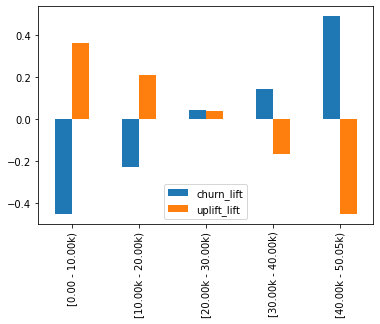

In [19]:
churn_from_dummy = sum_result_by_quantile['churn_value'] - sum_result_by_quantile['dummy_value']
uplift_from_dummy = sum_result_by_quantile['uplift_value'] - sum_result_by_quantile['dummy_value']
lift_from_dummy = pd.concat((churn_from_dummy, uplift_from_dummy), axis=1)
lift_from_dummy /= ONE_MILLION
lift_from_dummy.columns = ['churn_lift', 'uplift_lift']
lift_from_dummy.plot(kind='bar')

In [20]:
lift_from_dummy

,churn_lift,uplift_lift
[0.00 - 10.00k),-0.452,0.364
[10.00k - 20.00k),-0.226,0.211
[20.00k - 30.00k),0.045,0.040
[30.00k - 40.00k),0.142,-0.164
[40.00k - 50.05k),0.491,-0.451


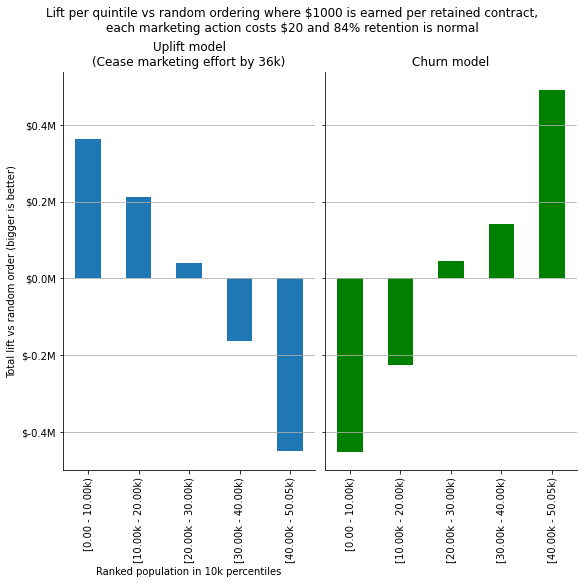

In [21]:
fig, axs = plt.subplot_mosaic([['Uplift', 'Churn']], sharex=True, sharey=True, figsize=(8, 8), constrained_layout=True)
lift_from_dummy['uplift_lift'].plot(kind='bar', ax=axs['Uplift'])
lift_from_dummy['churn_lift'].plot(kind='bar', ax=axs['Churn'], color='g')
title = f'Uplift model\n(Cease marketing effort by {int(row_with_minimum_uplift_effect/1000)}k)'
set_common_mpl_styles(ax=axs['Uplift'], ylabel='Total lift vs random order (bigger is better)', 
                      title=title, xlabel='Ranked population in 10k percentiles')
set_common_mpl_styles(ax=axs['Churn'], title='Churn model')
title = f"Lift per quintile vs random ordering where \${VALUE_PER_RETAINED_CONTRACT:0.0f} is earned per retained contract,\neach marketing action costs ${MARKETING_COST_PER_INSURED:0.0f} and 84% retention is normal"
fig.suptitle(title);
axs['Uplift'].get_legend().remove()
axs['Churn'].get_legend().remove()
axs['Uplift'].yaxis.set_major_formatter(StrMethodFormatter('${x:2.1f}M'))

In [22]:
datetime.datetime.now()

datetime.datetime(2022, 2, 18, 16, 14, 21, 551828)